# THE SOURCE

In [1]:
"""The purpose of this report is to do an analyzation of the Donald Trump Twitter account and design a predictive model
    to predict the exact source of an individual tweet from the Donald Trump account. The result of the analysis will then be used
    as a factor in a seperate model design to show the effect of Donal Trump's Twitter on the financial markets."""

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import string
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

%matplotlib inline

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read in files
trump_16 = pd.read_json('tweets_2016.json')
trump_17 = pd.read_json('tweets_2017.json')
trump_16.sort_index(ascending=False, inplace = True)
trump_17.sort_index(ascending =False, inplace = True)
trump = trump_16.append(trump_17, ignore_index=True)
trump.shape

(5884, 8)

# Preprocessing and Feature Addition

The dataset consists of 5884 individual tweets and from Midnight Janbuary 1, 2016 to 11:00 p.m. on September 17, 2017. There are 8 different characteristics to every observation

1) Time created 

2) Number of Likes 

3) Id of Individual Tweet 

4) Id of User tweet replies to(if applicable) 

5) Tweet is Retweet(if applicable)

6) Number of times tweet was retweeted

7) Source

8) Tweet

The text of the data will have to preprocessed and features will need to be added for a complete analyzation to take place.

Let's start with an overall investigation of the dataset. 

In [3]:
#preprocess trump tweets by removing all twitter special characters, leaving only the words of the text.
trump.text = trump.text.apply(lambda x: re.sub(r"&\S+", "", x, flags=re.MULTILINE))
trump.text = trump.text.apply(lambda x: re.sub(r"@\S+", "", x, flags=re.MULTILINE))
trump.text = trump.text.apply(lambda x: re.sub(r"http\S+", "", x, flags=re.MULTILINE))
trump.text = trump.text.apply(lambda x: re.sub(r'\d+', '',x, flags=re.MULTILINE))

In [4]:
trump.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
0,2016-01-01 00:44:14,6735,682723973449289728,NaN,False,2108,Twitter for Android,"I will be on live, with members of my family..."
1,2016-01-01 03:25:27,8581,682764544402440192,NaN,False,3460,Twitter for iPhone,HAPPY NEW YEAR THANK YOU!
2,2016-01-01 05:18:23,9143,682792967736848384,NaN,False,3434,Twitter for iPhone,#HappyNewYearAmerica!
3,2016-01-01 06:07:28,8258,682805320217980928,NaN,False,1948,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...
4,2016-01-01 06:08:06,7490,682805477168779264,NaN,False,2721,Twitter for Android,""" Hillary said she was in a ""Fog of War"" as ex..."


In [5]:
trump.tail()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
5879,2017-09-15 22:58:30,44914,908827394856947712,NaN,False,11823,Twitter for iPhone,"We will defend our people, our nations and our..."
5880,2017-09-15 23:54:00,71686,908841360131743744,NaN,False,17473,Media Studio,HAPPY th BIRTHDAY to the The American people ...
5881,2017-09-16 22:40:23,22322,909185223887347712,NaN,False,4691,Twitter for iPhone,A great deal of good things happening for our ...
5882,2017-09-16 22:59:06,13697,909189931154771968,NaN,False,3347,Twitter for iPhone,Attorney General Bill Shuette will be a fantas...
5883,2017-09-16 23:04:03,11893,909191177810915328,NaN,False,2504,Twitter for iPhone,"I will be in Huntsville, Alabama, on Saturday ..."


In [6]:
trump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5884 entries, 0 to 5883
Data columns (total 8 columns):
created_at                 5884 non-null datetime64[ns]
favorite_count             5884 non-null int64
id_str                     5884 non-null int64
in_reply_to_user_id_str    35 non-null float64
is_retweet                 5884 non-null bool
retweet_count              5884 non-null int64
source                     5884 non-null object
text                       5884 non-null object
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 327.6+ KB


The is_reply_to_user_id column only has 35 values, the id_str column has no repeat values and is not of use for analyzation or predicitve modeling. Both columns can be dropped from the dataset.

In [7]:
trump.drop('id_str', axis=1, inplace=True)
trump.drop('in_reply_to_user_id_str', axis=1, inplace=True)

In [8]:
trump[trump['is_retweet']==True].count()

created_at        377
favorite_count    377
is_retweet        377
retweet_count     377
source            377
text              377
dtype: int64

Less than 5% of the tweets are something Donald Trump has retweeted, but will leave it in the dataset to see what types of things he retweets.

In [9]:
trump[trump['is_retweet']==True].text[0:5]

26     RT  So proud to be out on the campaign trail w...
91     RT  Explosive Trump attack on HRC, Bill, Monic...
167    RT  REUTERS ROLLING:  TRUMP %, CRUZ .%, BUSH ....
187    RT      obvious to all that he raised some GRE...
239     RT  I look forward to being on  with  at :pmET. 
Name: text, dtype: object

Now lets investigate the target vartiable, the source of each individual tweet.

In [10]:
trump['source'].value_counts()

Twitter for iPhone     3221
Twitter for Android    2116
Twitter Web Client      358
Twitter Ads              96
Media Studio             65
Twitter for iPad         22
Instagram                 2
TweetDeck                 2
Mobile Web (M5)           1
Periscope                 1
Name: source, dtype: int64

Over 95% of the dataset comes one of three sources and any investigation can focus solely on Twitter for IPhone, Twitter for Android and Twitter Web Client.

In [11]:
# Training dataframe with observations from three relevan sources only
trump = trump[trump.source != 'Twitter Ads']
trump = trump[trump.source != 'Media Studio']
trump = trump[trump.source != 'Twitter for iPad']
trump = trump[trump.source != 'TweetDeck']
trump = trump[trump.source != 'Instagram']
trump = trump[trump.source != 'Periscope']
trump = trump[trump.source != 'Mobile Web (M5)']

In [12]:
# Check the data types for the remaining columns
trump.dtypes

created_at        datetime64[ns]
favorite_count             int64
is_retweet                  bool
retweet_count              int64
source                    object
text                      object
dtype: object

The final step in the preprocessing of the dataset is to make the index a datetime index

In [13]:
#Make dataframe a datetime index
trump.index=pd.DatetimeIndex(trump['created_at'])
trump.drop('created_at', axis = 1, inplace =True)
trump.shape

(5695, 5)

So our preprocessed dataset consist of 5695 observations and 5 characteristics for each observation

# Data Analyzation


Let's start by generating any new features that might be impoprtant factors in the source classification.

In [14]:
# Obtain the hour of the day and the day of the week for each observation and add them as features to the dataframe
trump['hours'] = trump.index.hour
trump['weekday'] = trump.index.weekday_name

## Natural Language Processing

In [15]:
from nltk.corpus import stopwords

# get english stop words
english = stopwords.words('english')

Specific packages within Python allow us to analyze written text for both its Meta and Text attributes.


### Meta Attributes:

Meta attributes include:

1) Number of words per tweet

2) Number of unique words in tweet

3) Number of characters in tweet

4) Number of stopwords

5) Number of punctuation

6) Number of upper case words

7) Number of title case words

8) Average length of word

In [16]:
# Number of words in tweet
trump['num_words'] = trump['text'].apply(lambda x: len(str(x).split()))

# Number of unique word per tweet
trump['num_unique_words'] = trump['text'].apply(lambda x: len(set(str(x).split())))

# Number of characters in tweet
trump['num_char'] = trump['text'].apply(lambda x: len(str(x)))

# Number of stop words
trump['num_stops'] = trump['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in english]))

# Number of puncuation in tweet
trump['num_punc'] = trump['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of upper case words
trump['num_upper'] = trump['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in tweet
trump['num_title'] = trump['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of word
# trump['avg_len'] = trump['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))



In [17]:
trump.head()

,favorite_count,is_retweet,retweet_count,source,text,hours,weekday,num_words,num_unique_words,num_char,num_stops,num_punc,num_upper,num_title
created_at,,,,,,,,,,,,,,
2016-01-01 00:44:14,6735,False,2108,Twitter for Android,"I will be on live, with members of my family...",0,Friday,25,24,122,12,7,6,5
2016-01-01 03:25:27,8581,False,3460,Twitter for iPhone,HAPPY NEW YEAR THANK YOU!,3,Friday,5,5,28,0,1,5,0
2016-01-01 05:18:23,9143,False,3434,Twitter for iPhone,#HappyNewYearAmerica!,5,Friday,1,1,22,0,2,0,0
2016-01-01 06:07:28,8258,False,1948,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,6,Friday,16,16,86,8,3,0,4
2016-01-01 06:08:06,7490,False,2721,Twitter for Android,""" Hillary said she was in a ""Fog of War"" as ex...",6,Friday,25,24,125,11,7,2,7


Let's plot some of the new variables to see any correlation. Obviously, we will start with difference in the number of words in a Tweet depending on the source.

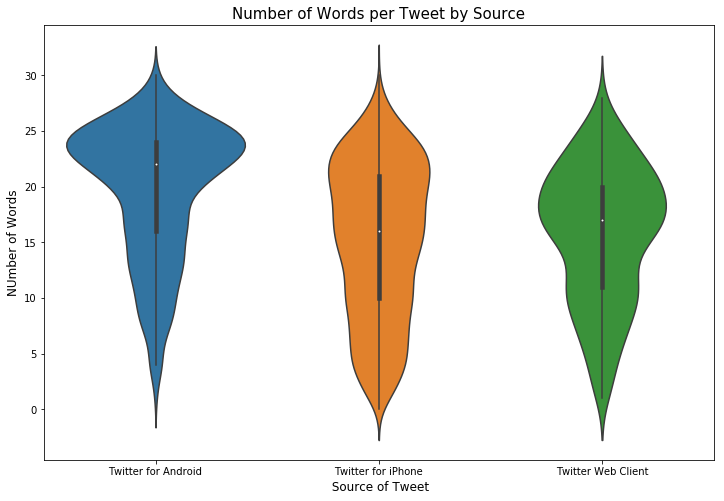

In [18]:
plt.figure(figsize=(12,8))
sns.violinplot(x='source', y= 'num_words', data= trump)
plt.xlabel(' Source of Tweet', fontsize=12)
plt.ylabel('NUmber of Words', fontsize=12)
plt.title('Number of Words per Tweet by Source', fontsize=15)

There is a significantly higher mean with the android source versus the other two but the distibutions of the sources is consistent with each other. Basically, this graph says that the android source was used much more for Tweets ranging from 20-30 words. i.e. longer tweets.

Next let's investigate the amount of punctuation in each by source

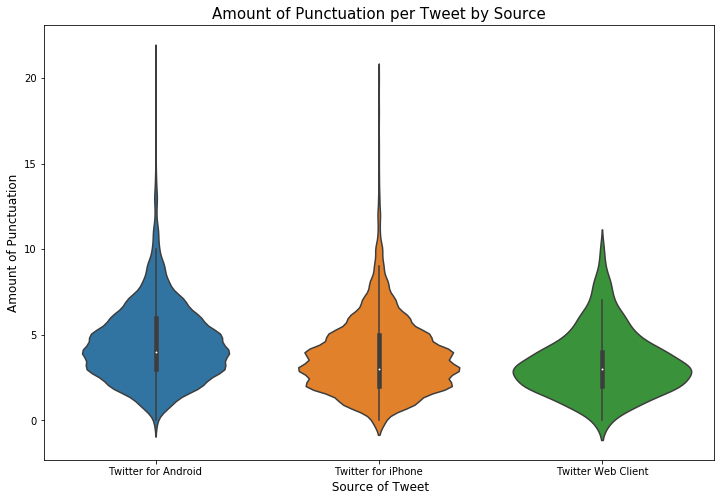

In [19]:
plt.figure(figsize=(12,8))
sns.violinplot(x=trump['source'], y= 'num_punc', data= trump)
plt.xlabel(' Source of Tweet', fontsize=12)
plt.ylabel('Amount of Punctuation', fontsize=12)
plt.title('Amount of Punctuation per Tweet by Source', fontsize=15)

There are some outliers within the Android and iPhone sources but the Web Client is normally distributed. The outliers can be dealt with by taking the log of the Android and iPhone punctuation values.

In [20]:
trump['num_punc']= trump['num_punc'].apply(lambda x: np.log(x))

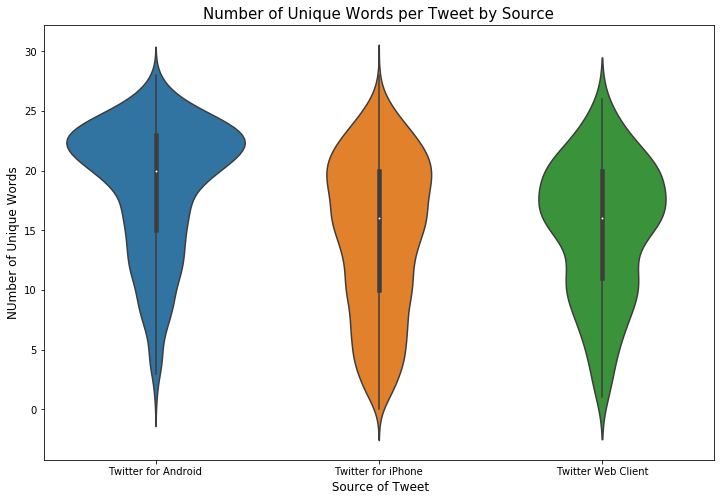

In [21]:
plt.figure(figsize=(12,8))
sns.violinplot(x=trump.source, y= 'num_unique_words', data= trump)
plt.xlabel(' Source of Tweet', fontsize=12)
plt.ylabel('NUmber of Unique Words', fontsize=12)
plt.title('Number of Unique Words per Tweet by Source', fontsize=15)

As expected there is some obvious correlation between number of words and the number of unique words. The graphs are nearly identical.

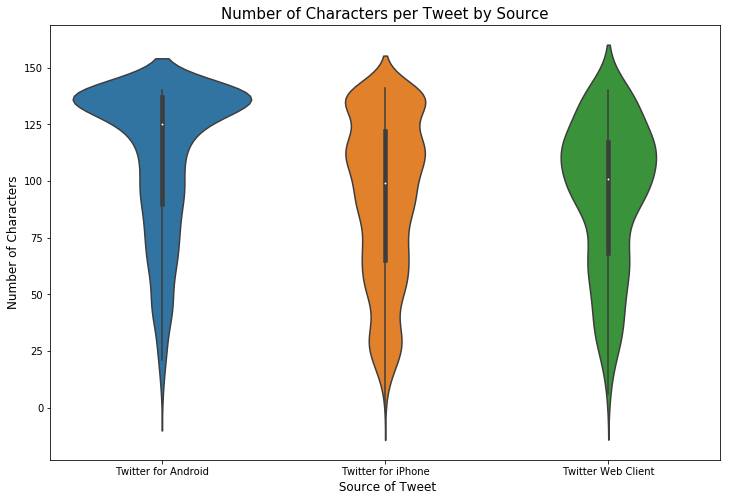

In [22]:
plt.figure(figsize=(12,8))
sns.violinplot(x=trump.source, y= 'num_char', data= trump)
plt.xlabel(' Source of Tweet', fontsize=12)
plt.ylabel('Number of Characters', fontsize=12)
plt.title('Number of Characters per Tweet by Source', fontsize=15)

Outliers on the low side of the charcter per tweet count might require another log function

In [23]:
trump['num_char']=trump['num_char'].apply(lambda x: np.log(x))

In [55]:
don = trump[trump['source']=='Twitter for Android']

In [57]:
analyser = SentimentIntensityAnalyzer()

com=[]
for idx, text in enumerate(trump.text):
    snt = analyser.polarity_scores(text)
    com.append(snt['compound'])
    

trump['com']=com

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
don.head()

,favorite_count,is_retweet,retweet_count,source,text,hours,weekday,num_words,num_unique_words,num_char,num_stops,num_punc,num_upper,num_title,com
created_at,,,,,,,,,,,,,,,
2016-01-01 00:44:14,6735,0,2108,Twitter for Android,"I will be on live, with members of my family...",0,Friday,25,24,4.804021,12,1.945910,6,5,0.7519
2016-01-01 06:08:06,7490,0,2721,Twitter for Android,""" Hillary said she was in a ""Fog of War"" as ex...",6,Friday,25,24,4.828314,11,1.945910,2,7,-0.8478
2016-01-01 21:29:56,3330,0,933,Twitter for Android,""" they're spending millions but you're still...",21,Friday,14,14,4.356709,2,1.609438,0,2,0.7351
2016-01-01 23:00:09,8495,0,2642,Twitter for Android,"Well, the year has officially begun. I have ma...",23,Friday,27,27,4.934474,14,1.098612,1,2,0.6325
2016-01-01 23:02:05,2780,0,654,Twitter for Android,""" we love u to Trump Family. God bless you.""",23,Friday,10,10,3.806662,2,1.386294,0,3,0.8442


One of the first attributes that is important , to any Presidential election, is the overall sentiment of their tweets. The polarizing nature of the 2016 Election, along with Donald Trump's incessant use of Twitter, only makes this attribute more interesting. Python's NLTK VaderSentiment package attempts to interpret the sentiment from any blurb of text.